# 06 — Random Forest Notebook
- Grid: n_estimators {300,600,900}, max_features {'sqrt',0.3,0.5}, min_samples_leaf {1,3,5}


In [2]:
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

In [6]:
# local utils
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from utils_plots import plot_pred_vs_actual, plot_residuals, report_mse

# load train/test data
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'data')
train_path = os.path.join(DATA_DIR, 'concrete_train.csv')
test_path  = os.path.join(DATA_DIR, 'concrete_test.csv')

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

X_train = train_df.drop(columns=['concrete_compressive_strength'])
y_train = train_df['concrete_compressive_strength'].values
X_test  = test_df.drop(columns=['concrete_compressive_strength'])
y_test  = test_df['concrete_compressive_strength'].values

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [8]:
param_grid = {
    'n_estimators': [300, 600, 900],
    'max_features': ['sqrt', 0.3, 0.5],
    'min_samples_leaf': [1, 3, 5]
}

rf = RandomForestRegressor(random_state=598, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=598)
gcv = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, refit=True)
gcv.fit(X_train, y_train)

print("Best params:", gcv.best_params_)
print("CV MSE:", -gcv.best_score_)

Best params: {'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 900}
CV MSE: 27.007380356823887


In [11]:
y_pred_test = gcv.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("Test MSE:", test_mse)

Test MSE: 29.558372355331212


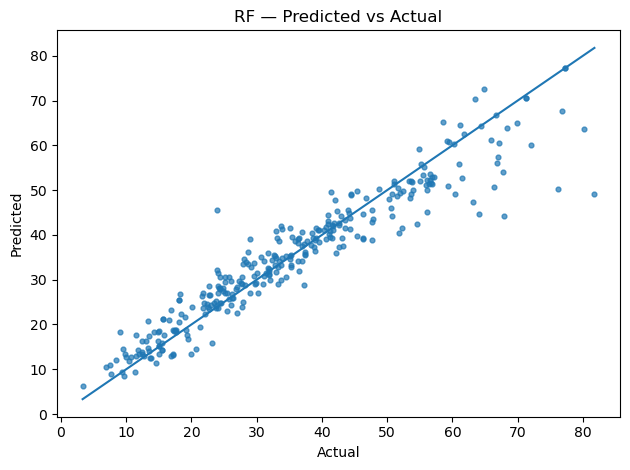

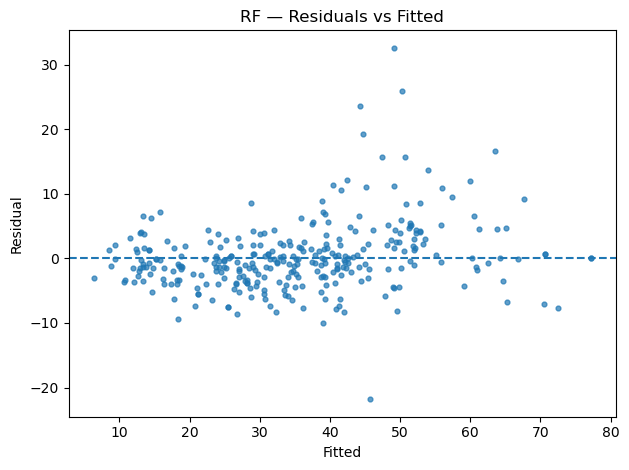

In [13]:
fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'reports', 'figures')
os.makedirs(fig_dir, exist_ok=True)
plot_pred_vs_actual(y_test, y_pred_test, title='RF — Predicted vs Actual', save_path=os.path.join(fig_dir, 'rf_pv.png'))
plot_residuals(y_test, y_pred_test, title='RF — Residuals vs Fitted', save_path=os.path.join(fig_dir, 'rf_resid.png'))

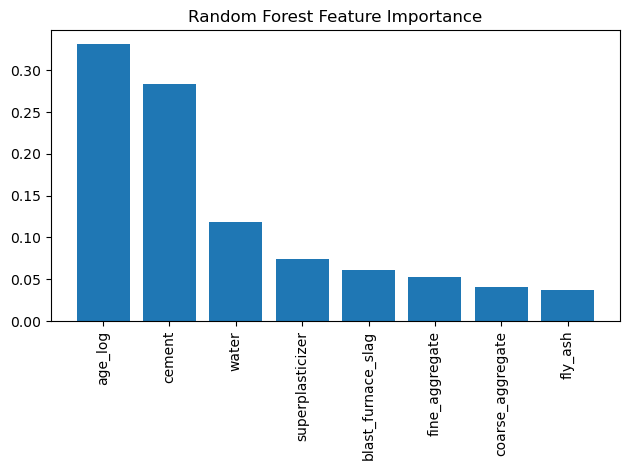

In [15]:
# Feature importance
importances = gcv.best_estimator_.feature_importances_
feat_names = X_train.columns if hasattr(X_train, 'columns') else [f'x{i}' for i in range(len(importances))]

idx = np.argsort(importances)[::-1]
plt.figure()
plt.bar(range(len(importances)), importances[idx])
plt.xticks(range(len(importances)), np.array(feat_names)[idx], rotation=90)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'rf_importance.png'), dpi=160)
plt.show()